# Import and Init Sample Data

# TODO Extention Ideas:
# Imply higher Relevancy to Basic Feature Representation Maps (Line & Co)
# Potentially freeze early feature representations (simulate genetic cues / evolution information that cannot change in lifetime)
# Regularize Weights relative to Areas / Distances limiting dense layers
# Push Networks into smaller Subnetworks that learn similar Representation & combine allow more robustness
# Possibly Double CNNs with only Dense Layer at last (Idea: a bunch of Smaller Autoencoders)

In [471]:
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import pandas as pd
from jax import nn
from flax import linen as nn

In [472]:
X = random.multivariate_normal(
    key=random.PRNGKey(0),
    shape=(100,),
    mean=jnp.array([1, 3]),
    cov=jnp.array([[1.0, -0.5], [-0.5, 2.0]]),
)

In [473]:
X.shape

(100, 2)

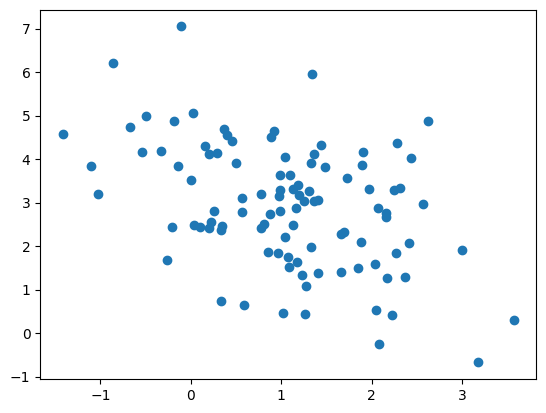

In [474]:
plt.scatter(X[:, 0], X[:, 1])

# Define NNs

In [475]:
class Encoder(nn.Module):
    bottleneck_dim: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.bottleneck_dim)(x)
        return x
    
class Decoder(nn.Module):
    output_dim: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_dim)(x)
        return x

In [476]:
enc = Encoder(bottleneck_dim=1)
dec = Decoder(output_dim=2)

params_enc = enc.init(random.PRNGKey(0), X)
X_bottlenecked = enc.apply(params_enc, X)
X_bottlenecked.shape

(100, 1)

In [477]:
print(enc.tabulate(random.PRNGKey(0), X))

print(dec.tabulate(random.PRNGKey(0), X_bottlenecked))


                               Encoder Summary                                
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs         ┃ outputs        ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Encoder │ float32[100,2] │ float32[100,1] │                      │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_0 │ Dense   │ float32[100,2] │ float32[100,5] │ bias: float32[5]     │
│         │         │                │                │ kernel: float32[2,5] │
│         │         │                │                │                      │
│         │         │                │                │ 15 (60 B)            │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_1 │ Dense   │ float32[100,5] │ float32[100,1] │ bias: float32[1]     │
│         │         │                │             

In [478]:
class AE(nn.Module):
    bottleneck_dim: int
    output_dim: int
    
    def setup(self) -> None:
        self.encoder = Encoder(bottleneck_dim=self.bottleneck_dim)
        self.decoder = Decoder(output_dim=self.output_dim)
    
    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [479]:
X.shape

(100, 2)

In [480]:
bottleneck_dim = 1
output_dim = X.shape[1]
ae = AE(bottleneck_dim, output_dim)
ae

AE(
    # attributes
    bottleneck_dim = 1
    output_dim = 2
)

In [481]:
params = ae.init(random.PRNGKey(0), X)
X_hat = ae.apply(params, X)
params

{'params': {'encoder': {'Dense_0': {'kernel': Array([[ 0.15134847, -0.32299334,  0.08520892, -0.8511846 , -0.01199674],
           [-0.57142776, -0.5397128 ,  0.8611557 ,  1.0071576 , -0.07660278]],      dtype=float32),
    'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
   'Dense_1': {'kernel': Array([[ 0.13227113],
           [-0.01840949],
           [ 0.2201205 ],
           [ 0.9453392 ],
           [ 0.05011441]], dtype=float32),
    'bias': Array([0.], dtype=float32)}},
  'decoder': {'Dense_0': {'kernel': Array([[-1.2452307 ,  0.44543535, -0.3655867 ,  1.39154   , -0.69316494]],      dtype=float32),
    'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
   'Dense_1': {'kernel': Array([[-0.7021354 , -0.4109914 ],
           [-0.33507746,  0.44580737],
           [ 0.12096553, -0.27334633],
           [-0.61274064,  0.5017541 ],
           [ 0.4895522 , -0.08537559]], dtype=float32),
    'bias': Array([0., 0.], dtype=float32)}}}}

In [482]:
encoded_1d = Encoder(bottleneck_dim).apply({"params": params["params"]["encoder"]},X).flatten()
encoded_1d

Array([3.4963102 , 3.108627  , 0.9320544 , 4.057727  , 0.30273172,
       0.11544382, 2.3909185 , 3.1876478 , 2.2277427 , 0.10497344,
       7.77171   , 3.804624  , 2.88809   , 1.994378  , 2.6063747 ,
       5.1840186 , 2.8382902 , 3.0449672 , 0.316491  , 2.4316764 ,
       2.713921  , 3.4093592 , 1.7087218 , 0.2694838 , 1.9926288 ,
       2.3670845 , 5.038891  , 3.1983416 , 5.067685  , 2.9958732 ,
       2.1596475 , 5.923744  , 0.54839146, 5.7720003 , 4.776969  ,
       1.6664495 , 3.8151255 , 3.2540715 , 4.6736603 , 3.364921  ,
       8.134441  , 2.9352021 , 2.4815805 , 1.3510447 , 2.238839  ,
       4.49261   , 0.27957022, 0.9230136 , 1.4577025 , 0.28765818,
       3.618376  , 2.9667673 , 2.959128  , 2.1144266 , 4.4614096 ,
       2.6928544 , 2.4369533 , 2.3768072 , 4.884745  , 0.06151014,
       4.502951  , 0.1407348 , 1.2879452 , 1.9558234 , 1.376677  ,
       2.7097945 , 0.5696248 , 6.3300643 , 1.4658453 , 1.31498   ,
       4.44231   , 0.22757171, 3.275959  , 0.10868369, 2.68567

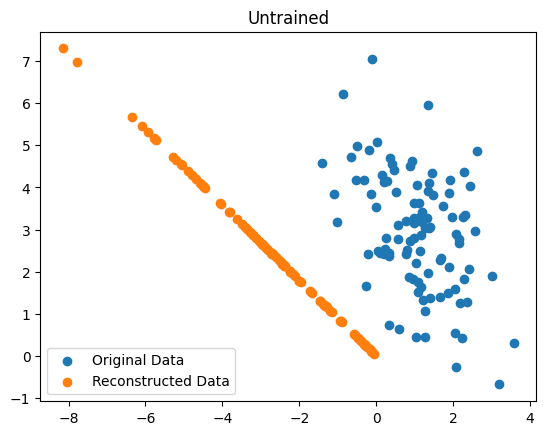

In [483]:
def plot_2d_reconstruction(X, params, model, trained = False):
    X_hat = model.apply(params, X)
    plt.scatter(X[:, 0], X[:, 1], label="Original Data")
    plt.scatter(X_hat[:, 0], X_hat[:, 1], label="Reconstructed Data")
    plt.legend()
    if trained:
        plt.title("Trained")
    else:
        plt.title("Untrained")
        
plot_2d_reconstruction(X, params, ae, False)

In [484]:
residual = X- X_hat

l1_loss = residual.sum(axis=1).mean()
l2_loss = (residual**2).sum(axis=1).mean() / 2

In [485]:
l2_loss

Array(8.188855, dtype=float32)

In [486]:
(jnp.linalg.norm(residual, ord=2, axis=1) ** 2).mean() / 2

Array(8.188855, dtype=float32)

In [487]:
# 2x since Optax not using Bishop "Pattern Recognition and Machine Learning"
2 * optax.l2_loss(X_hat, X).mean()

Array(8.188855, dtype=float32)

In [488]:
@jax.jit
def l2_loss(params, X):
    X_hat = ae.apply(params, X)
    return 2 * optax.l2_loss(X_hat, X).mean()

l2_loss(params, X)

Array(8.188855, dtype=float32)

In [489]:
def train(
        X: jnp.array,
        optimizer: optax._src.base.GradientTransformation,
        model: nn.Module,
        key_param: jax.random.PRNGKey,
        n_iters: int = 300,
        print_every: int = 10,
):
    loss_array = np.zeros(n_iters)
    def loss(params, X):
        return l2_loss(params, X)
    params = model.init(key_param, X)
    opt_state = optimizer.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    
    for i in range(n_iters):
        loss_val, grads = loss_grad_fn(params, X)
        loss_array[i] = loss_val.item()
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if i % print_every == 0:
            print("Loss step {}: ".format(i), loss_val)
    return params, loss_array

In [490]:
optimized_params, loss_array = train(
    X, optax.adam(learning_rate=0.1), ae, jax.random.PRNGKey(0), n_iters=60
)

Loss step 0:  8.188855
Loss step 10:  1.2781012
Loss step 20:  0.6263661
Loss step 30:  0.5582065
Loss step 40:  0.40481868
Loss step 50:  0.3825248


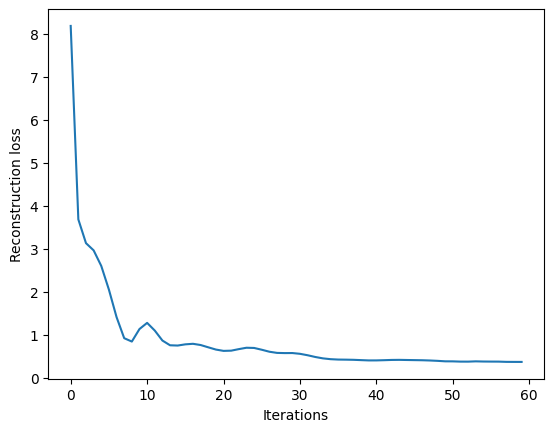

In [491]:
plt.plot(loss_array)
plt.xlabel("Iterations")
_ = plt.ylabel("Reconstruction loss")

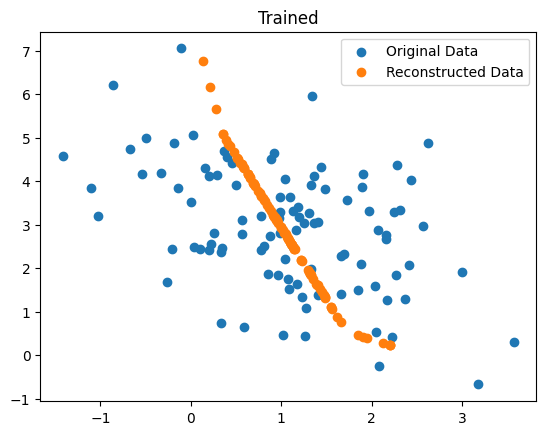

In [492]:
plot_2d_reconstruction(X, optimized_params, ae, True)

# 2d Sinusoid Data (Complex Test)

In [493]:
def generate_2d_sinusoidal_curve(key, n_points=100, noise_std=0.05):
    key_t, key_noise = jax.random.split(key)
    x = jnp.linspace(0, 4 * jnp.pi, n_points)
    y = jnp.sin(x)
    curve = jnp.stack([x, y], axis=1)  # (100, 2)

    # Add Gaussian noise
    noise = jax.random.normal(key_noise, shape=curve.shape) * noise_std
    noisy_curve = curve + noise

    return noisy_curve

def plot_2d_reconstruction(X, params, model,active_size, trained = False):
    X_hat = model.apply(params, X, active_size)
    
    # Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(X[:, 0], X[:, 1], label='Noisy 2D Sinusoidal Curve', lw=2, c='blue')
    ax.scatter(X[:, 0], X[:, 1], s=15, c='black', alpha=0.6)
    
    ax.plot(X_hat[:, 0], X_hat[:, 1], label='Reconstructed 2D Sinusoidal Curve', lw=2, c='orange')
    ax.scatter(X_hat[:, 0], X_hat[:, 1], s=15, c='black', alpha=0.6)
    
    if trained:
        plt.title("Trained Sinusoidal Curve")
    else:
        plt.title("Untrained Sinusoidal Curve")
    ax.set_ylabel('y = sin(x)')
    ax.set_xlabel('x')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    
def plot_2d_reconstruction_overlay(X, params, model, active_sizes, trained=False):
    # Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # Original noisy curve
    ax.plot(X[:, 0], X[:, 1], label='Original 2D Curve', lw=2, c='blue')
    ax.scatter(X[:, 0], X[:, 1], s=15, c='black', alpha=0.6)

    # Colors for each active size
    colors = ['orange', 'green', 'red', 'purple', 'cyan']
    
    for i, active_size in enumerate(active_sizes):
        X_hat = model.apply(params, X, active_size)
        color = colors[i % len(colors)]
        ax.plot(X_hat[:, 0], X_hat[:, 1], lw=2, label=f'Reconstructed (size={active_size})', c=color)
        ax.scatter(X_hat[:, 0], X_hat[:, 1], s=15, alpha=0.4, c=color)
    
    if trained:
        plt.title("Trained Sinusoidal Curve Reconstruction")
    else:
        plt.title("Untrained Sinusoidal Curve Reconstruction")
        
    ax.set_ylabel('y = sin(x)')
    ax.set_xlabel('x')
    ax.legend()
    plt.tight_layout()
    plt.show()



In [494]:
# Generate data
key = jax.random.PRNGKey(0)
X = generate_2d_sinusoidal_curve(key)


In [495]:
X.shape

(100, 2)

# Incremental Bottleneck Expansion Autoencoder

In [496]:
class ExpandingEncoder(nn.Module):
    # Mask out all Bottleneck dims < max bottleneck
    max_bottleneck_dim: int
    
    @nn.compact
    def __call__(self, x, active_size):
        x = nn.Dense(64, name="enc1")(x)
        x = nn.relu(x)
        z = nn.Dense(self.max_bottleneck_dim, name="bottleneck")(x)
        
        # Mask out Non active Bottleneck Size
        #mask = jnp.arange(self.max_bottleneck_dim) < active_size
        #z = z * mask
        return z
    
class Decoder(nn.Module):
    output_dim: int
    max_bottleneck_dim: int
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(64, name="dec1")(z)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim, name="output")(x)
        return x

class ExpandingAutoencoder(nn.Module):
    bottleneck_dim: int
    output_dim: int
    
    def setup(self):
        self.encoder = ExpandingEncoder(max_bottleneck_dim=self.bottleneck_dim)
        self.decoder = Decoder(output_dim=self.output_dim, max_bottleneck_dim=self.bottleneck_dim)

    def __call__(self, x, active_size):
        # Get full bottleneck representation
        z_full = self.encoder(x, active_size)
        
        # Create mask: active dimensions get gradients, inactive are zeroed and stopped
        active_mask = jnp.arange(self.bottleneck_dim) < active_size
        inactive_mask = ~active_mask
        
        # Split into active and inactive parts
        z_active = z_full * active_mask[None, :]  # Keep active dimensions
        z_inactive = jax.lax.stop_gradient(z_full * inactive_mask[None, :])  # Stop gradients for inactive
        
        # Combine: active parts can learn, inactive parts are masked to zero
        z_masked = z_active + z_inactive * 0.0  # Inactive parts contribute zero
        
        return self.decoder(z_masked)
        #return self.decoder(z)

In [497]:
X.shape

(100, 2)

In [498]:
bottleneck_dim = 10
output_dim = X.shape[1]
eae = ExpandingAutoencoder(bottleneck_dim, output_dim)

In [499]:
eae_params  = eae.init(random.PRNGKey(0), X, active_size=2)
eae_params

{'params': {'encoder': {'enc1': {'kernel': Array([[-0.8978475 , -0.82330436,  0.5568902 , -0.3119257 , -0.35396957,
            -1.1110059 ,  1.1430233 ,  0.32158896,  0.51358867, -0.6406446 ,
            -0.36771867,  0.16860443, -0.30702814, -0.07121194, -0.12273043,
            -0.2944617 ,  0.00310719,  0.04886566, -0.60042614, -0.26898292,
            -0.5384361 ,  0.18287621, -0.00320968, -0.07935743,  0.2397725 ,
             1.4246634 , -0.4814801 , -0.2619467 ,  0.05650076,  0.66576034,
             0.3026091 , -0.98648524,  0.47237283,  0.15823105, -0.02108455,
            -1.0952224 , -0.6068736 , -0.79334253,  0.2907529 , -0.4975986 ,
             0.66383994, -0.14049795,  0.10610407, -0.39910492,  0.2837405 ,
            -0.39638555, -0.4944841 , -0.9990381 , -1.4068836 , -0.38148963,
             0.27462947, -1.2317386 ,  0.00829016,  0.23804381,  0.05713331,
             0.6516754 , -1.3561032 ,  0.02737125, -0.38692483, -0.8608636 ,
            -0.14909206, -0.73333085,

In [500]:
X_hat = eae.apply(eae_params, X, 2)
X_hat.shape

(100, 2)

In [501]:
print(eae.tabulate(random.PRNGKey(0), X, active_size=1))


                          ExpandingAutoencoder Summary                          
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ ExpandingAut… │ -             │ float32[100,… │              │
│               │               │ float32[100,… │               │              │
│               │               │ -             │               │              │
│               │               │ active_size:  │               │              │
│               │               │ 1             │               │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ encoder       │ ExpandingEnc… │ -             │ float32[100,… │              │
│               │               │ float32[100,… │               │              │
│               │          

In [502]:
eae_params['params']['encoder'].keys()

dict_keys(['enc1', 'bottleneck'])

In [503]:
eae_params['params']['encoder']['enc1']

{'kernel': Array([[-0.8978475 , -0.82330436,  0.5568902 , -0.3119257 , -0.35396957,
         -1.1110059 ,  1.1430233 ,  0.32158896,  0.51358867, -0.6406446 ,
         -0.36771867,  0.16860443, -0.30702814, -0.07121194, -0.12273043,
         -0.2944617 ,  0.00310719,  0.04886566, -0.60042614, -0.26898292,
         -0.5384361 ,  0.18287621, -0.00320968, -0.07935743,  0.2397725 ,
          1.4246634 , -0.4814801 , -0.2619467 ,  0.05650076,  0.66576034,
          0.3026091 , -0.98648524,  0.47237283,  0.15823105, -0.02108455,
         -1.0952224 , -0.6068736 , -0.79334253,  0.2907529 , -0.4975986 ,
          0.66383994, -0.14049795,  0.10610407, -0.39910492,  0.2837405 ,
         -0.39638555, -0.4944841 , -0.9990381 , -1.4068836 , -0.38148963,
          0.27462947, -1.2317386 ,  0.00829016,  0.23804381,  0.05713331,
          0.6516754 , -1.3561032 ,  0.02737125, -0.38692483, -0.8608636 ,
         -0.14909206, -0.73333085, -1.0937086 ,  1.3216966 ],
        [-0.43794218, -0.67231184,  0.16

In [504]:
eae_params['params']['encoder']['bottleneck']['kernel'].shape

(64, 10)

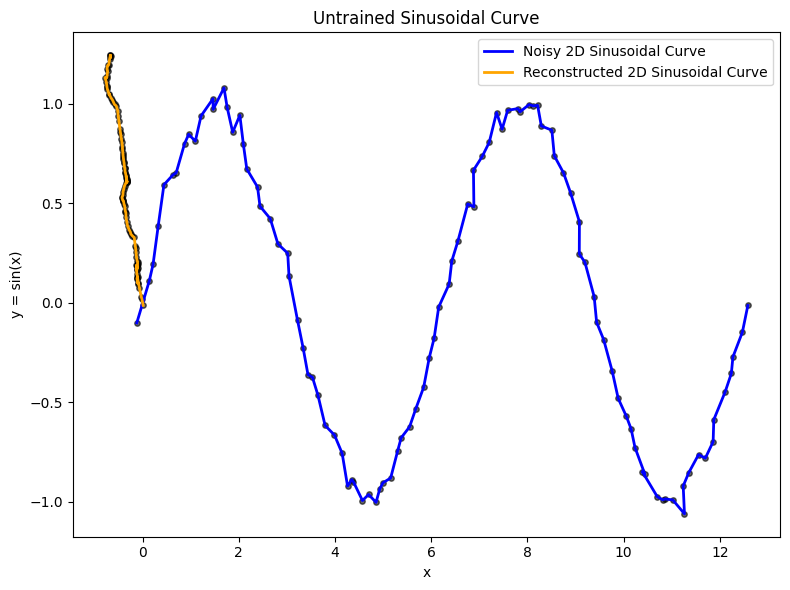

In [505]:
plot_2d_reconstruction(X, eae_params,eae, 10)

In [506]:
from flax.core import freeze, unfreeze

def update_bottleneck_weights(params, old_size, new_size):
    p = unfreeze(params)

    w = p['params']['encoder']['bottleneck']['kernel']  # (128, bottleneck_size)
    b = p['params']['encoder']['bottleneck']['bias']    # (bottleneck_size,)

    # sample noise for new added neurons
    mean_w = jnp.mean(w[:, :old_size], axis=1, keepdims=True)
    std_w = jnp.std(w[:, :old_size], axis=1, keepdims=True)
    noise_w = random.normal(random.PRNGKey(0), new_size.item()) * 0.1 * std_w + mean_w
    
    mean_b = jnp.mean(b[:old_size])
    std_b = jnp.std(b[:old_size])
    noise_b = random.normal(random.PRNGKey(0), new_size.item()) * 0.1 * std_b + mean_b

    w = w.at[:, old_size:new_size].set(noise_w[:, old_size:new_size])
    #w = w.at[:, old_size:new_size].set(jnp.tile(mean_w, (1, new_size - old_size)))
    b = b.at[old_size:new_size].set(noise_b[old_size:new_size])
    #b = b.at[old_size:new_size].set(mean_b)

    p['params']['encoder']['bottleneck']['kernel'] = w
    p['params']['encoder']['bottleneck']['bias'] = b

    return freeze(p)


In [507]:
bottleneck_dim = 64
output_dim = X.shape[1]
eae = ExpandingAutoencoder(bottleneck_dim, output_dim)

params = eae.init(jax.random.PRNGKey(0), X, active_size=32)

# Active sizes per epoch
sizes = jnp.repeat(jnp.arange(32, 48, 2), repeats=5)
#sizes = jnp.linspace(16, 64, 32)
prev_size = sizes[0]

optimizer = optax.adam(10e-5)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(p,x, active_size):
    x_hat = eae.apply(p, x, active_size)
    return jnp.mean((x_hat - x) ** 2)  # MSE loss

@jax.jit
def train_step(params, opt_state, x, active_size):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, active_size)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

for epoch, active_size in enumerate(sizes):
    print(f"Epoch {epoch+1}, Active Size: {active_size}")

    if active_size > prev_size:
        params = update_bottleneck_weights(params, prev_size, active_size)
        
        # Reinitialize optimizer for new parameters
        opt_state = optimizer.init(params)
        prev_size = active_size

    params, opt_state, loss = train_step(params, opt_state, X, active_size)
    print("Loss:", loss)


Epoch 1, Active Size: 32
Loss: 23.738705
Epoch 2, Active Size: 32
Loss: 23.43532
Epoch 3, Active Size: 32
Loss: 23.134102
Epoch 4, Active Size: 32
Loss: 22.83518
Epoch 5, Active Size: 32
Loss: 22.538382
Epoch 6, Active Size: 34
Loss: 22.267075
Epoch 7, Active Size: 34
Loss: 21.970913
Epoch 8, Active Size: 34
Loss: 21.677883
Epoch 9, Active Size: 34
Loss: 21.389639
Epoch 10, Active Size: 34
Loss: 21.106148
Epoch 11, Active Size: 36
Loss: 20.850874
Epoch 12, Active Size: 36
Loss: 20.5741
Epoch 13, Active Size: 36
Loss: 20.301344
Epoch 14, Active Size: 36
Loss: 20.032438
Epoch 15, Active Size: 36
Loss: 19.76698
Epoch 16, Active Size: 38
Loss: 19.778969
Epoch 17, Active Size: 38
Loss: 19.508274
Epoch 18, Active Size: 38
Loss: 19.239754
Epoch 19, Active Size: 38
Loss: 18.9734
Epoch 20, Active Size: 38
Loss: 18.709684
Epoch 21, Active Size: 40
Loss: 18.359404
Epoch 22, Active Size: 40
Loss: 18.094606
Epoch 23, Active Size: 40
Loss: 17.832678
Epoch 24, Active Size: 40
Loss: 17.573301
Epoch 25

# Masked Gradients for past 16

In [513]:
grads = jax.grad(loss_fn)(params, X, 16)
bottleneck_grads = grads['params']['encoder']['bottleneck']
kernel_grads = bottleneck_grads['kernel']
for i in range(min(36, kernel_grads.shape[1]))[::2]:
                grad_mag = np.mean(np.abs(kernel_grads[:, i]))
                status = "🟢 ACTIVE" if i < 16 else "🔴 MASKED"
                print(f"    Dim {i}: {grad_mag:.6f} {status}")


    Dim 0: 0.331148 🟢 ACTIVE
    Dim 2: 0.192760 🟢 ACTIVE
    Dim 4: 0.161914 🟢 ACTIVE
    Dim 6: 0.121968 🟢 ACTIVE
    Dim 8: 0.818106 🟢 ACTIVE
    Dim 10: 0.955897 🟢 ACTIVE
    Dim 12: 1.385727 🟢 ACTIVE
    Dim 14: 0.695333 🟢 ACTIVE
    Dim 16: 0.000000 🔴 MASKED
    Dim 18: 0.000000 🔴 MASKED
    Dim 20: 0.000000 🔴 MASKED
    Dim 22: 0.000000 🔴 MASKED
    Dim 24: 0.000000 🔴 MASKED
    Dim 26: 0.000000 🔴 MASKED
    Dim 28: 0.000000 🔴 MASKED
    Dim 30: 0.000000 🔴 MASKED
    Dim 32: 0.000000 🔴 MASKED
    Dim 34: 0.000000 🔴 MASKED


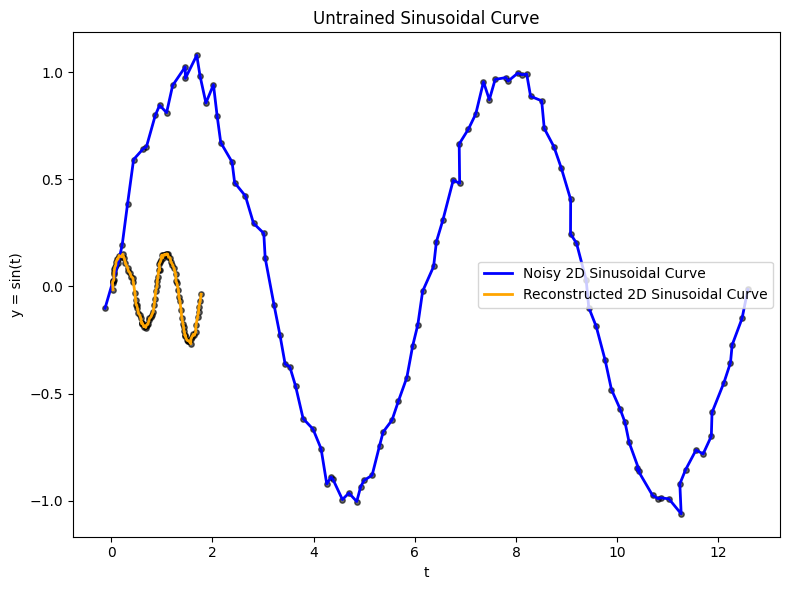

In [460]:
plot_2d_reconstruction(X, params,eae, 16)

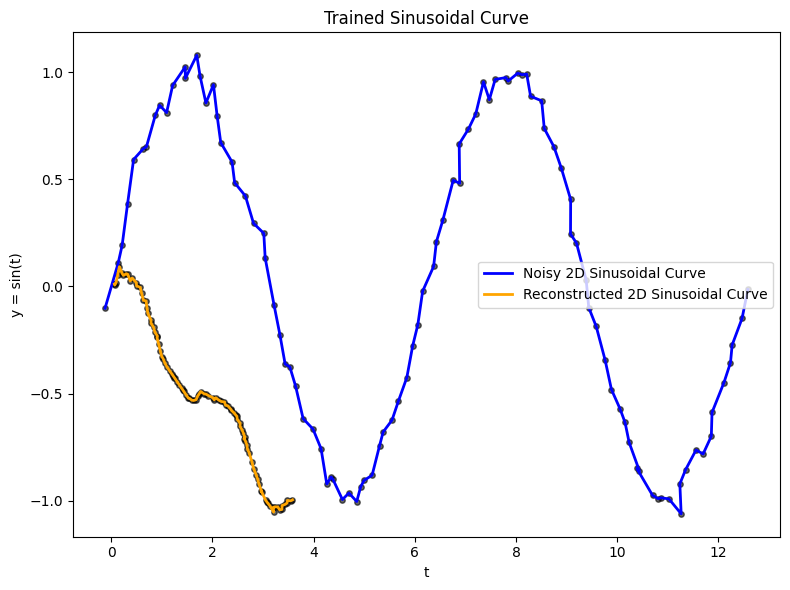

In [461]:
plot_2d_reconstruction(X, params,eae, 32, True)

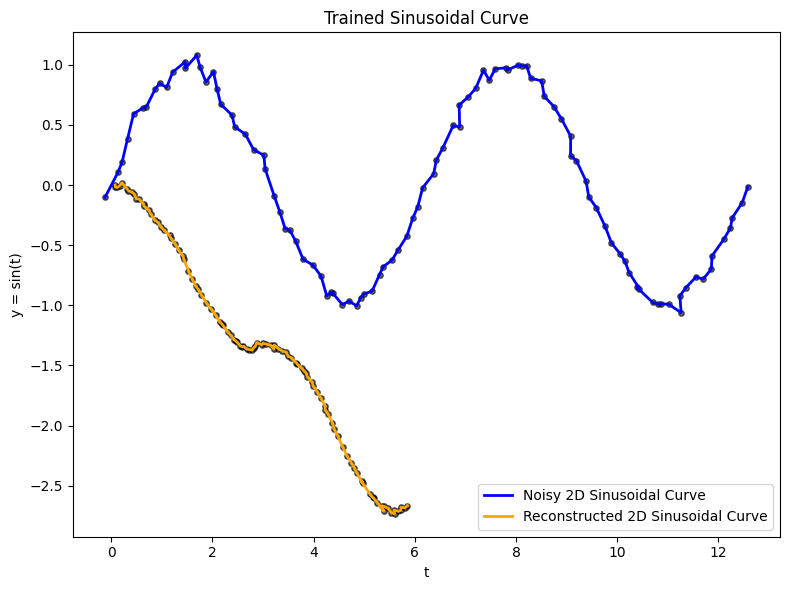

In [462]:
plot_2d_reconstruction(X, params,eae, 64, True)

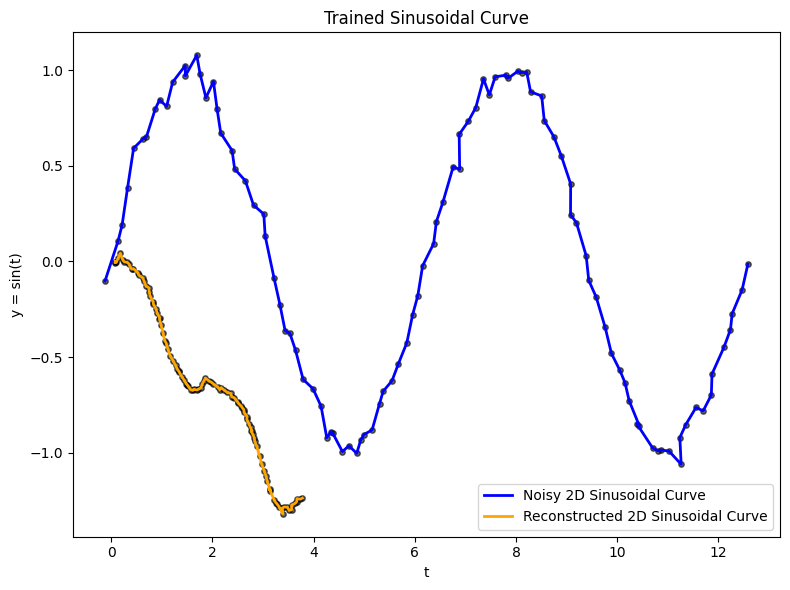

In [463]:
plot_2d_reconstruction(X, params,eae, 48, True)

In [464]:
jnp.mean((eae.apply(params, X, 48) - X) ** 2)

Array(13.123794, dtype=float32)

In [465]:
jnp.mean((eae.apply(params, X, 64) - X) ** 2)

Array(8.572972, dtype=float32)

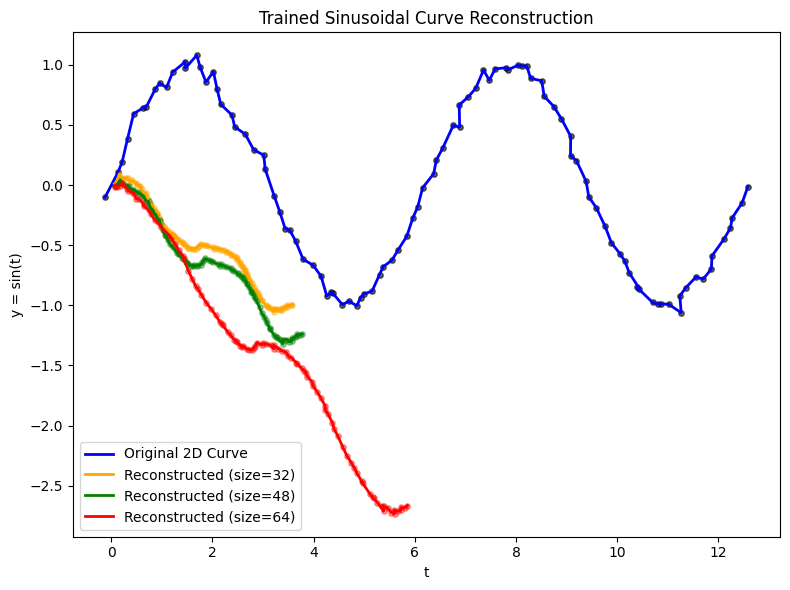

In [467]:
# Error goes Up with adding of untrained Neurons
plot_2d_reconstruction_overlay(X, params, eae, [32, 48, 64], trained=True)